### Research Question

Media plays a crucial role in shaping public perception, yet different news sources often frame the same event in varied ways, reflecting ideological biases. This study seeks to explore the extent to which media sources differ in their framing of news and how machine learning can be used to categorize statements by their ideological alignment. By leveraging natural language processing (NLP) techniques and machine learning models, this research aims to classify news articles based on ideological bias—left, neutral, or right—thus contributing to the broader discourse on media objectivity and automated content analysis.

Previous research has demonstrated the effectiveness of machine learning techniques in identifying media bias and political ideology in news articles. Several key studies provide a strong foundation for this investigation:

Fiore (2019) explores the automatic identification of political ideology in online news, highlighting that machine learning classifiers can outperform human annotators in categorizing ideological leanings. The study underscores the potential of text-based features such as word usage, sentiment, and topic modeling in detecting political bias, reinforcing the feasibility of automated classification techniques.

Chao et al. (2022) apply bidirectional Long Short-Term Memory (BiLSTM) neural networks to analyze media bias and content quality. Their findings suggest that deep learning models, particularly those leveraging contextual embedding methods such as word2vec, BERT, and LLaMA, significantly improve classification performance by capturing nuanced semantic differences in political discourse.

Martín-Forero et al. (2022) examine traditional machine learning approaches, including Random Forest and Logistic Regression, for political ideology detection. Their study finds that these models perform competitively, even without deep learning, suggesting that ensemble learning techniques—such as boosting and stacking—can further enhance classification accuracy. Additionally, the research highlights the importance of feature engineering, including source credibility and citation patterns, in improving model interpretability.

Research Question:

To what extent do media sources differ in their framing of news, and how can machine learning be used to categorize statements by their ideological alignment?

Task Type: Multi-Class Classification

The problem of identifying ideological bias in news content can be framed as a multi-class classification task, where statements are categorized into three distinct ideological groups:
	•	Left (Liberal/Progressive)
	•	Neutral (Centrist, Objective)
	•	Right (Conservative)

This is a supervised learning problem, where models are trained on labeled datasets containing news articles with known ideological orientations.

Machine Learning Models for Evaluation

To determine the most effective approach, a combination of traditional, deep learning, and ensemble models will be evaluated:

Baseline Models (Traditional Machine Learning)
	•	Random Forest: A tree-based model capable of capturing feature interactions.
	•	Logistic Regression: A simple, interpretable model for analyzing word impact.

Deep Learning Models (Advanced NLP)
	•	LLaMA (Large Language Model Meta AI): A state-of-the-art transformer-based model known for its accuracy in NLP tasks.
	•	Bidirectional LSTM (BiLSTM): A recurrent neural network model that effectively captures contextual dependencies in political language.

Ensemble and Boosting Methods
	•	Boosting (XGBoost, AdaBoost, LightGBM): Techniques that iteratively refine weak classifiers for improved performance.
	•	Stacking (Hybrid Model): Combining multiple models (e.g., blending Random Forest, LLaMA, and BiLSTM) to enhance classification accuracy.


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import json

### Load in the data

In [77]:
df = pd.read_csv('/Users/apple/Desktop/30100-final/data/data_random_split.csv')

In [78]:
df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split
0,coronavirus,The Guardian,0,https://www.theguardian.com/world/2020/mar/26/...,US coronavirus stimulus checks: are you eligib...,2020-03-26,Lauren Aratani,Most taxpayers will get a check from the $ 2tn...,Most taxpayers will get a check from the $2tn ...,www.theguardian.com,left,IBgtqEHUEcjyMriR,train
1,healthcare,Washington Times,2,http://www.washingtontimes.com/news/2013/feb/1...,After Obamacare health exchange deadline passe...,2013-02-16,Tom Howell Jr.,The backbone of President Obama ’ s health car...,The backbone of President Obama’s health care ...,www.washingtontimes.com,right,LC3zdsbACLILzBhY,train
2,politics,National Review,2,https://www.nationalreview.com/2019/08/the-doj...,The DOJ Will Not Prosecute James Comey over Tr...,2019-08-03,"Andrew C. Mccarthy, John Mccormack, Michael Br...",Then-FBI Director James Comey testifying on Ca...,Then-FBI Director James Comey testifying on Ca...,www.nationalreview.com,right,W084H19Vniu1Z24f,train
3,media_bias,NPR Online News,1,https://www.npr.org/2018/08/27/642356784/fox-n...,Fox News Hasn't Always Shared Robert Driscoll'...,2018-08-27,David Folkenflik,Fox News Has n't Always Shared Robert Driscoll...,Fox News Hasn't Always Shared Robert Driscoll'...,www.npr.org,center,Lcvv69hlu4J5Foc3,train
4,trade,Bloomberg,1,https://www.bloomberg.com/news/articles/2019-0...,"Wilbur Ross Says U.S., China ‘Miles and Miles’...",2019-01-24,"Brendan Murray, Andrew Mayeda",LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,www.bloomberg.com,center,ZW7MmqXMtiJgL6jY,train


In [79]:
df.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID', 'split'],
      dtype='object')

In [80]:
#check missing values in the dataset
df.isnull().sum()

topic                  0
source                 0
bias                   0
url                    0
title                  0
date                4039
authors             9262
content                0
content_original       0
source_url             0
bias_text              0
ID                     0
split                  0
dtype: int64

### Text Preprocessing

In [81]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def tokenize_and_tfidf(df, text_column='content_original', model_name="bert-base-uncased"):
    """
    Tokenizes text using a Transformer tokenizer and applies TF-IDF vectorization.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a column with text data.
    - text_column (str): Column name that contains raw text.
    - model_name (str): Hugging Face model to use for tokenization.

    Returns:
    - tfidf_matrix (sparse matrix): TF-IDF transformed matrix of tokenized text.
    - feature_names (list): List of TF-IDF feature names (tokens).
    """

    # Enable progress bar
    tqdm.pandas()


    custom_stopwords = list(ENGLISH_STOP_WORDS.union({
        'caption', 'click', 'toggle', 'reprint', 'advertisement', 
        'image', 'copyright', 'enlarge', 'newsletter', 
        'images', 'monitor', 'daily', 'mr', 'replay','inbox', 'subscribe'
    }))

    # remove stopwords with automatic tokenizer
    tfidf = TfidfVectorizer(
    stop_words=custom_stopwords, 
    max_features=5000, 
    min_df=5, 
    token_pattern=r'[a-zA-Z]{2,}'  # Ensure words have at least 2 letters
    )
    tfidf_matrix = tfidf.fit_transform(df[text_column])

    return tfidf_matrix, tfidf.get_feature_names_out()

In [82]:
# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='content_original')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Display sample feature names (tokens)
print("Sample Tokens:", feature_names[:10])

TF-IDF Matrix Shape: (36274, 5000)
Sample Tokens: ['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'ability' 'able' 'abortion'
 'abortions' 'abrams']


In [83]:
# convert the matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()

,aaron,abandon,abandoned,abbott,abc,ability,able,abortion,abortions,abrams,...,york,yorker,young,younger,youth,youtube,zelensky,zero,zone,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.03759,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.010812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# remove numeric tokens in tfidf_df
def remove_numeric_tokens(text):
    return " ".join([word for word in text.split() if not re.fullmatch(r"\d+", word)])

# Apply the function to the 'content' column
df['clean_text'] = df['content_original'].apply(remove_numeric_tokens)

# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='clean_text')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (36274, 5000)


In [85]:
tfidf_df = tfidf_matrix
tfidf_df =pd.DataFrame(tfidf_df.toarray(), columns=feature_names)
tfidf_df.head()

,aaron,abandon,abandoned,abbott,abc,ability,able,abortion,abortions,abrams,...,york,yorker,young,younger,youth,youtube,zelensky,zero,zone,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.03759,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.010812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

### Tree-Based Model

In [86]:
df["split"].value_counts()

split
train    27978
valid     6996
test      1300
Name: count, dtype: int64

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Convert TF-IDF matrix to array
X = tfidf_matrix.toarray()
y = df['bias']

X_train = X[df["split"] == "train"]
y_train = y[df["split"] == "train"]
X_val = X[df["split"] == "valid"]
y_val = y[df["split"] == "valid"]
X_test = X[df["split"] == "test"]
y_test = y[df["split"] == "test"]

In [88]:
print("Training Set Shape:", X_train.shape, y_train.shape)

Training Set Shape: (27978, 5000) (27978,)


In [89]:
# Train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_val)

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Random Forest Accuracy: 0.7803030303030303
Classification Report:
               precision    recall  f1-score   support

        left       0.74      0.78      0.76      2438
      center       0.86      0.77      0.81      1998
       right       0.76      0.79      0.78      2560

    accuracy                           0.78      6996
   macro avg       0.79      0.78      0.78      6996
weighted avg       0.78      0.78      0.78      6996



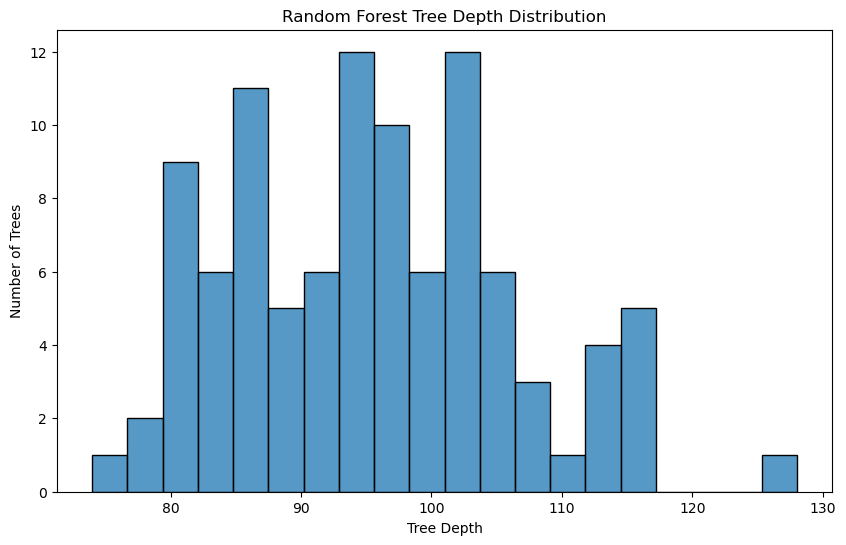

In [90]:
# Visualize the depth of the trees
plt.figure(figsize=(10, 6))
sns.histplot([estimator.tree_.max_depth for estimator in rf_clf.estimators_], bins=20)
plt.title('Random Forest Tree Depth Distribution')
plt.xlabel('Tree Depth')
plt.ylabel('Number of Trees')
plt.show()

In [91]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter for RandomizedSearch
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [30, 50, 100, 125, 150],     # Depth of trees
    'min_samples_split': [2, 5, 10]   # Minimum samples per split
}

# Run RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, verbose=2, n_iter=15)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Train final model with best params
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_val)

# Evaluate tuned model
print("Tuned Random Forest Accuracy:", accuracy_score(y_val, y_pred_best))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END max_depth=150, min_samples_split=10, n_estimators=300; total time=  10.3s
[CV] END max_depth=150, min_samples_split=10, n_estimators=300; total time=   9.3s
[CV] END max_depth=150, min_samples_split=10, n_estimators=300; total time=   8.3s
[CV] END max_depth=125, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END max_depth=125, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END max_depth=125, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END max_depth=150, min_samples_split=10, n_estimators=1000; total time=  27.4s
[CV] END max_depth=150, min_samples_split=10, n_estimators=1000; total time=  27.7s
[CV] END max_depth=150, min_samples_split=10, n_estimators=1000; total time=  28.6s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  28.4s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  28.3s
[CV] END max_depth=125, mi

In [92]:
print(classification_report(y_val, y_pred_best, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.79      0.77      0.78      2438
      center       0.88      0.79      0.83      1998
       right       0.77      0.84      0.80      2560

    accuracy                           0.80      6996
   macro avg       0.81      0.80      0.81      6996
weighted avg       0.81      0.80      0.80      6996



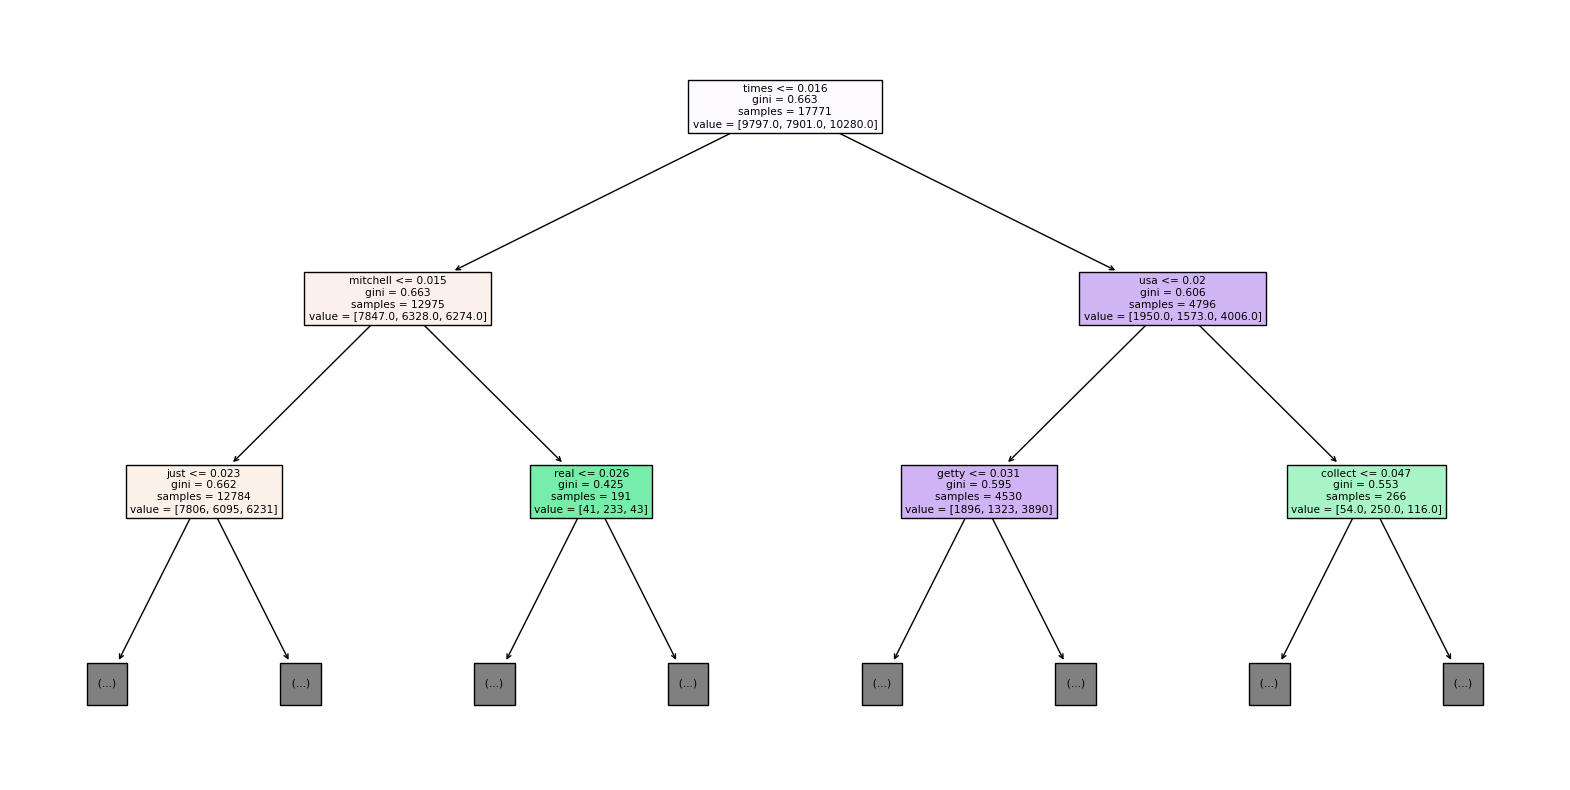

In [93]:
# plot one of the trees
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_names, filled=True, max_depth=2)
plt.show()

### Error Analysis


In [94]:
# show the errors of the model
error_df = df[df['split'] == 'valid'].copy()
error_df['predicted_bias'] = y_pred_best
error_df['correct'] = error_df['bias'] == error_df['predicted_bias']
error_df[error_df['correct'] == False][['content_original', 'bias', 'predicted_bias']].head(10)

,content_original,bias,predicted_bias
29283,"Donald Trump will release “very, very specific...",0,2
29290,Let's not even go into the attacks on reproduc...,0,2
29297,"As a convicted felon, Bruce Sartwell isn't leg...",2,0
29300,Trump’s longtime fixer returned to his New Yor...,0,1
29311,Jobless claims soared again in early April as ...,2,0
29318,Egypt's president on Thursday issued constitut...,2,0
29331,The Trump administration and its Republican en...,0,2
29336,A new report obtained by Townhall from the non...,2,0
29341,(Larry Ye/Dreamstime)\n\nAn economist makes a ...,2,0
29342,(CNN) President Donald Trump described an admi...,0,2


The model struggles with distinguishing between left (0) and right (2) biases, often misclassifying left-leaning text as right and vice versa, suggesting feature overlap or dataset imbalance. PCA is great at helping with this.

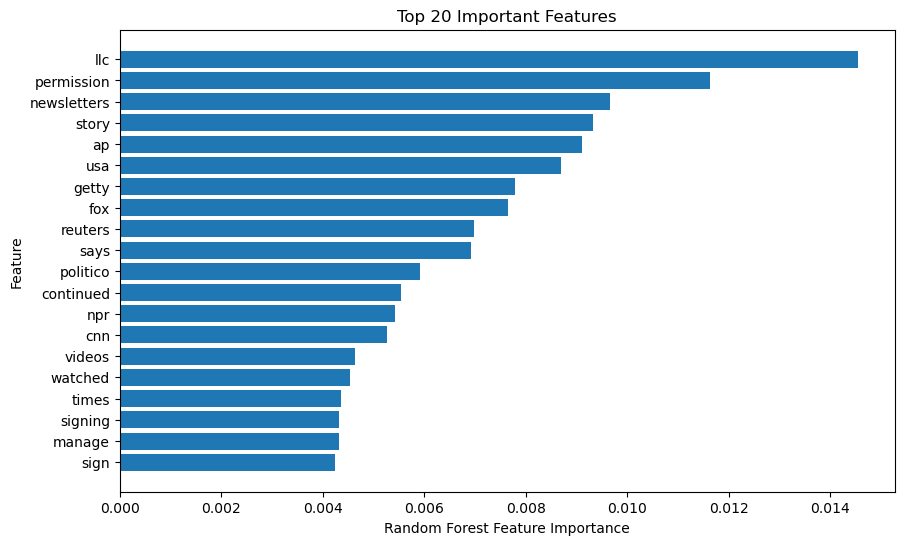

In [95]:
#plot the feature importance
feature_importance = best_rf.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(np.arange(20), feature_importance[sorted_idx][-20:])
plt.yticks(np.arange(20), np.array(feature_names)[sorted_idx][-20:])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")
plt.show()


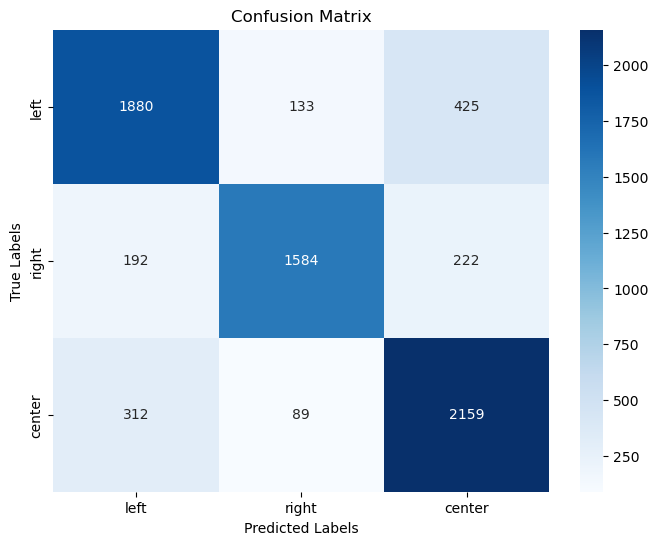

In [96]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define biases
biases = df['bias_text'].unique()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=biases, yticklabels=biases)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The model overpredicts “Center”, frequently misclassifying Left and Right as Center.

### PCA

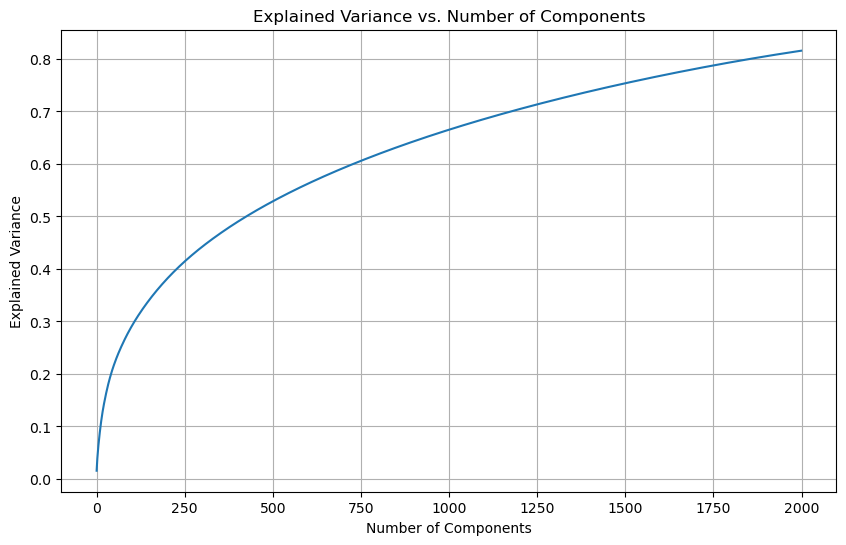

In [97]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initialize PCA with 2000 components
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(X)    # Fit and transform the data


# Plot explained variance to find the best n_components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


In [98]:
# Apply PCA with optimal components
pca = PCA(n_components=1800)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on PCA-reduced features
rf_clf_pca = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_clf_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = rf_clf_pca.predict(X_val_pca)
accuracy_pca = accuracy_score(y_val, y_pred_pca)
classification_report_pca = classification_report(y_val, y_pred_pca, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy after PCA:", accuracy_pca)
print("Classification Report:\n", classification_report_pca)

Random Forest Accuracy after PCA: 0.5723270440251572
Classification Report:
               precision    recall  f1-score   support

        left       0.59      0.54      0.56      2438
      center       0.78      0.30      0.44      1998
       right       0.52      0.81      0.64      2560

    accuracy                           0.57      6996
   macro avg       0.63      0.55      0.55      6996
weighted avg       0.62      0.57      0.55      6996



To improve classification performance, we applied Principal Component Analysis (PCA) to reduce dimensionality before training the Random Forest model. However, the results show that PCA significantly worsened the accuracy, dropping from 0.70 (original model) to 0.54. The recall for the “Center” class plummeted to 0.23, indicating that the model now struggles even more with detecting center-leaning samples. Additionally, while recall for the “Right” class remains high (0.81), its precision is weak (0.50), leading to frequent false positives. Compared to the previous Random Search-tuned Random Forest model, PCA has degraded performance, making it ineffective for this classification task. This suggests that dimensionality reduction removed important features, highlighting the need for better feature selection or deep learning models instead.

After fine-tuning through Random Search, the Random Forest model achieved 70% accuracy, effectively classifying left, center, and right biases, with high recall for “Right” (0.86) and balanced precision. However, it struggled with misclassifying “Left” and “Right” as “Center”, leading to low recall for “Center” (0.56) and low precision for “Right” (0.61), indicating frequent false positives. To address these issues, we applied PCA for dimensionality reduction, but it significantly worsened the model’s performance, dropping accuracy to 0.54. The recall for “Center” plummeted to 0.23, while precision for “Right” fell to 0.50, suggesting PCA removed essential features rather than improving generalization.

These results reflect the broader challenge of how media sources differ in their framing of news—certain ideological alignments share linguistic features, making automatic classification difficult. Machine learning provides a promising approach to categorizing statements by ideological bias, but it requires robust feature engineering, class balancing, and advanced models to handle subtle contextual differences.